In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as tutils

In [2]:
# MNIST dataset
dataset = datasets.MNIST(root='./data',
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=100, 
                                          shuffle=True)

In [3]:
# MNIST dataset
test_dataset = datasets.MNIST(root='./data',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)
# Data loader
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=True)

In [4]:
IS_CUDA = False
if torch.cuda.is_available():
    IS_CUDA = True

In [20]:
def var(x):
    if IS_CUDA:
        x = x.cuda()
    return Variable(x)

# Reference: https://github.com/pytorch/vision/blob/master/test/sanity_checks.ipynb
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
trans = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [6]:
# Model 1: standard model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim = 400, z_dim = 20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim*2))
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid())
    
    def reparameterize(self, mu, log_var):
        epsilon = var(torch.randn(mu.size(0), mu.size(1)))
        z = mu + epsilon * torch.exp(log_var/2)
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim = 1)
        z = self.reparameterize(mu, log_var)
        out = self.decoder(z)
        return out, mu, log_var
    
    def sample(self, z):
        return self.decoder(z)
    
vae = VAE()
if IS_CUDA:
    vae.cuda()

In [6]:
# Model 2: New Layer for Mean and Variance
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim = 400, z_dim = 20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim))
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid())
        
        self.MuExtractor = nn.Sequential(
            nn.Linear(z_dim, z_dim),
            nn.Sigmoid())
        
        self.SigmaExtractor = nn.Sequential(
            nn.Linear(z_dim, z_dim),
            nn.Sigmoid())

    def reparameterize(self, mu, log_var):
        epsilon = var(torch.randn(mu.size(0), mu.size(1)))
        z = mu + epsilon * torch.exp(log_var/2)
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu = self.MuExtractor(h)
        log_var = self.SigmaExtractor(h)
        # mu, log_var = torch.chunk(h, 2, dim = 1)
        z = self.reparameterize(mu, log_var)
        out = self.decoder(z)
        return out, mu, log_var
    
    def sample(self, z):
        return self.decoder(z)
    
vae = VAE()
if IS_CUDA:
    vae.cuda()

In [6]:
# Model 3: Drop Mu size by Half and skip earlier middle layer
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim = 400, z_dim = 20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim))
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim/2, z_dim),
            nn.ReLU(),
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid())
        
        self.MuExtractor = nn.Sequential(
            nn.Linear(z_dim, z_dim/2),
            nn.Sigmoid())
        
        self.SigmaExtractor = nn.Sequential(
            nn.Linear(z_dim, z_dim/2),
            nn.Sigmoid())

    def reparameterize(self, mu, log_var):
        epsilon = var(torch.randn(mu.size(0), mu.size(1)))
        z = mu + epsilon * torch.exp(log_var/2)
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu = self.MuExtractor(h)
        log_var = self.SigmaExtractor(h)
        # mu, log_var = torch.chunk(h, 2, dim = 1)
        z = self.reparameterize(mu, log_var)
        out = self.decoder(z)
        return out, mu, log_var
    
    def sample(self, z):
        return self.decoder(z)
    
vae = VAE()
if IS_CUDA:
    vae.cuda()

In [5]:
# Model 4: Get single value for Mean and Variance
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim = 400, z_dim = 20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim))
        
        self.decoder = nn.Sequential(
            nn.Linear(1, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, z_dim),
            nn.ReLU(),
            nn.Linear(z_dim, image_size),
            nn.Sigmoid())
        
        self.MuExtractor = nn.Sequential(
            nn.Linear(z_dim, 1),
            nn.Sigmoid())
        
        self.SigmaExtractor = nn.Sequential(
            nn.Linear(z_dim, 1),
            nn.Sigmoid())

    def reparameterize(self, mu, log_var):
        epsilon = var(torch.randn(mu.size(0), mu.size(1)))
        z = mu + epsilon * torch.exp(log_var/2)
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu = self.MuExtractor(h)
        log_var = self.SigmaExtractor(h)
        # mu, log_var = torch.chunk(h, 2, dim = 1)
        z = self.reparameterize(mu, log_var)
        out = self.decoder(z)
        return out, mu, log_var
    
    def sample(self, z):
        return self.decoder(z)
    
vae = VAE()
if IS_CUDA:
    vae.cuda()

In [5]:
# Model 5: Drop Mean and Variance to 10
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim = 400, z_dim = 20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim))
        
        self.decoder = nn.Sequential(
            nn.Linear(10, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, z_dim),
            nn.ReLU(),
            nn.Linear(z_dim, image_size),
            nn.Sigmoid())
        
        self.MuExtractor = nn.Sequential(
            nn.Linear(z_dim, 10))
            #nn.Sigmoid())
        
        self.SigmaExtractor = nn.Sequential(
            nn.Linear(z_dim, 10))
            #nn.Sigmoid())

    def reparameterize(self, mu, log_var):
        epsilon = var(torch.randn(mu.size(0), mu.size(1)))
        z = mu + epsilon * torch.exp(log_var/2)
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu = self.MuExtractor(h)
        log_var = self.SigmaExtractor(h)
        # mu, log_var = torch.chunk(h, 2, dim = 1)
        z = self.reparameterize(mu, log_var)
        out = self.decoder(z)
        return out, mu, log_var
    
    def sample(self, z):
        return self.decoder(z)
    
vae = VAE()
if IS_CUDA:
    vae.cuda()

In [10]:
optimizer = torch.optim.Adam(vae.parameters(), lr = 0.001)

In [11]:
data_iter = iter(data_loader)
fixed_x,_ = next(data_iter)
torchvision.utils.save_image(fixed_x.cpu(), './data/real_images.png')
fixed_x = var(fixed_x.view(fixed_x.size(0), -1))

In [13]:
num_epochs = 10
# os.mkdir('./data/genImg/')

In [21]:
def train(outputImages, modelName):
    path = './data/genImg/'+modelName
    if not os.path.exists(path):
        os.mkdir(path)
    for epoch in range(num_epochs):
        for data in data_loader:
            img, _ = data
            img = var(img.view(img.size(0), -1))
            out, mu, log_var = vae(img)
            rc_loss = F.binary_cross_entropy(out, img, size_average=False)
            KL_div = torch.sum(0.5 * (mu ** 2 + torch.exp(log_var) - log_var - 1))

            total_loss = rc_loss + KL_div
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        print 'Epoch [{}/{}], Loss {:.4f}, Entropy: {:.4f}, KL: {: .4f} '.format(epoch+1, num_epochs, total_loss.data[0], rc_loss.data[0], KL_div.data[0])
        pic, _, _ = vae(fixed_x)
        pic = pic.view(pic.size(0), 1, 28, 28) 
        outputImages += [trans(pic)]
        torchvision.utils.save_image(pic.data.cpu(), path+'/image_{}.png'.format(epoch))
        show(tutils.make_grid(outputImages))
       

In [26]:
data_iter = iter(data_loader)

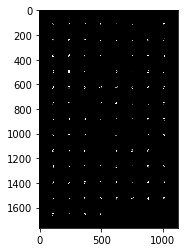

In [58]:
img, _ = data_iter.next()
img,_ = data_iter.next()
pic = img.view(img.size(0), 1, 28, 28)
imgList = [pic, pic, pic]
#show(torchvision.utils.make_grid(imgList, padding=100))
show(torchvision.utils.make_grid(img, padding=100))


TypeError: Invalid dimensions for image data

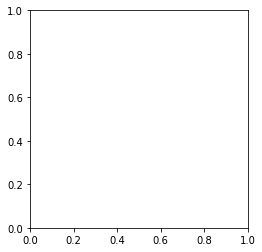

In [55]:
%matplotlib inline
grid = [torchvision.utils.make_grid(img).numpy().transpose((1, 2, 0))] * 3
plt.imshow(grid)

In [41]:
def Test():
    i = 0
    outputImages = []
    labels = []
    for data in test_data_loader:
        img, label = data
        img = var(img.view(img.size(0), -1))
        out, mu, log_var = vae(img)
        rc_loss = F.binary_cross_entropy(out, img, size_average=False)
        KL_div = torch.sum(0.5 * (mu ** 2 + torch.exp(log_var) - log_var - 1))

        total_loss = rc_loss + KL_div
        i += 1
        print i, ' Loss {:.4f}, Entropy: {:.4f}, KL: {: .4f} '.format(total_loss.data[0], rc_loss.data[0], KL_div.data[0])
        pic, _, _ = vae(fixed_x)
        pic = pic.view(pic.size(0), 1, 28, 28) 
        outputImages.append((out.data).cpu().numpy())
        labels.append(label)
        
    return outputImages, label

In [22]:
# Model 1
outputImages = []
train(outputImages, 'ExtractFromLayer')

Epoch [1/10], Loss 10979.6230, Entropy: 8425.0947, KL:  2554.5286 


TypeError: img should be PIL Image. Got <class 'torch.autograd.variable.Variable'>

In [42]:
predicted, labels = Test()

1  Loss 10230.0762, Entropy: 7683.6147, KL:  2546.4614 
2  Loss 10663.1680, Entropy: 8070.4014, KL:  2592.7671 
3  Loss 10300.2285, Entropy: 7728.0835, KL:  2572.1445 
4  Loss 9814.8135, Entropy: 7330.0122, KL:  2484.8013 
5  Loss 10073.9727, Entropy: 7487.5088, KL:  2586.4639 
6  Loss 10463.7324, Entropy: 7845.9434, KL:  2617.7886 
7  Loss 10432.4199, Entropy: 7829.6670, KL:  2602.7529 
8  Loss 10131.3926, Entropy: 7623.0684, KL:  2508.3245 
9  Loss 10031.3066, Entropy: 7550.1870, KL:  2481.1201 
10  Loss 9751.9102, Entropy: 7330.5024, KL:  2421.4080 
11  Loss 9910.4756, Entropy: 7395.8696, KL:  2514.6057 
12  Loss 10346.1104, Entropy: 7763.2529, KL:  2582.8572 
13  Loss 10368.8975, Entropy: 7782.8101, KL:  2586.0872 
14  Loss 10154.0918, Entropy: 7635.8120, KL:  2518.2798 
15  Loss 9963.4238, Entropy: 7446.4580, KL:  2516.9656 
16  Loss 9666.5293, Entropy: 7160.4912, KL:  2506.0381 
17  Loss 10263.4014, Entropy: 7695.4229, KL:  2567.9783 
18  Loss 9630.1650, Entropy: 7184.4604, KL:  

In [44]:
# Test
'''
pNum = np.array(predicted)
lNum = np.array(labels)
print pNum.shape, lNum.shape

x_test_encoded = pNum
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=lNum)
plt.colorbar()
plt.show()
'''

'\npNum = np.array(predicted)\nlNum = np.array(labels)\nprint pNum.shape, lNum.shape\n\nx_test_encoded = pNum\nplt.figure(figsize=(6, 6))\nplt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=lNum)\nplt.colorbar()\nplt.show()\n'

In [11]:
# Model 2
outputImages = []
train(outputImages, 'SameSizeNNDiff')

Epoch [1/10], Loss 18742.7168, Entropy: 18325.1270, KL:  417.5903 
Epoch [2/10], Loss 18859.0566, Entropy: 18439.0176, KL:  420.0390 
Epoch [3/10], Loss 17914.0098, Entropy: 17477.4941, KL:  436.5148 
Epoch [4/10], Loss 19026.9043, Entropy: 18609.7520, KL:  417.1521 
Epoch [5/10], Loss 18778.0293, Entropy: 18364.2324, KL:  413.7972 
Epoch [6/10], Loss 18179.8105, Entropy: 17758.8984, KL:  420.9129 
Epoch [7/10], Loss 18144.7070, Entropy: 17730.5508, KL:  414.1560 
Epoch [8/10], Loss 18379.2988, Entropy: 17948.3750, KL:  430.9247 
Epoch [9/10], Loss 19538.9688, Entropy: 19130.7754, KL:  408.1940 
Epoch [10/10], Loss 19493.7598, Entropy: 19092.1016, KL:  401.6581 


In [17]:
# Model 3
outputImages = []
train(outputImages, 'ReduceMuAndSigmaTo10')

Epoch [1/10], Loss 19722.6504, Entropy: 19512.7930, KL:  209.8571 
Epoch [2/10], Loss 20034.1035, Entropy: 19819.8984, KL:  214.2052 
Epoch [3/10], Loss 19196.9199, Entropy: 18977.1758, KL:  219.7438 
Epoch [4/10], Loss 18621.2422, Entropy: 18411.8965, KL:  209.3467 
Epoch [5/10], Loss 18940.5488, Entropy: 18722.9941, KL:  217.5538 
Epoch [6/10], Loss 18762.9883, Entropy: 18537.1777, KL:  225.8106 
Epoch [7/10], Loss 20092.7051, Entropy: 19881.1543, KL:  211.5514 
Epoch [8/10], Loss 18819.5293, Entropy: 18605.9922, KL:  213.5374 
Epoch [9/10], Loss 20054.7402, Entropy: 19841.6758, KL:  213.0651 
Epoch [10/10], Loss 18753.1641, Entropy: 18538.4453, KL:  214.7187 


In [11]:
# Model 3
outputImages = []
train(outputImages, 'ReduceMuAndSigmaTo10')

Epoch [1/30], Loss 20004.9863, Entropy: 19821.8867, KL:  183.0988 
Epoch [2/30], Loss 19018.4805, Entropy: 18797.4961, KL:  220.9853 
Epoch [3/30], Loss 19471.9512, Entropy: 19246.3516, KL:  225.5994 
Epoch [4/30], Loss 19667.0977, Entropy: 19462.9922, KL:  204.1059 
Epoch [5/30], Loss 19061.2812, Entropy: 18829.8535, KL:  231.4277 
Epoch [6/30], Loss 19780.3770, Entropy: 19567.8203, KL:  212.5567 
Epoch [7/30], Loss 19608.3301, Entropy: 19416.8789, KL:  191.4513 
Epoch [8/30], Loss 19320.1074, Entropy: 19113.2598, KL:  206.8474 
Epoch [9/30], Loss 19605.9688, Entropy: 19384.6113, KL:  221.3566 
Epoch [10/30], Loss 19354.1094, Entropy: 19121.4688, KL:  232.6412 
Epoch [11/30], Loss 18275.5449, Entropy: 18041.6602, KL:  233.8850 
Epoch [12/30], Loss 18717.7578, Entropy: 18494.1797, KL:  223.5786 
Epoch [13/30], Loss 18065.6484, Entropy: 17843.9355, KL:  221.7128 
Epoch [14/30], Loss 17948.4648, Entropy: 17720.8086, KL:  227.6559 
Epoch [15/30], Loss 17964.5371, Entropy: 17741.8125, KL: 

In [10]:
# Model 4
outputImages = []
train(outputImages, 'Rto1AndDecoderUnfoldsCorrectly')

Epoch [1/10], Loss 20389.1172, Entropy: 20357.9766, KL:  31.1408 
Epoch [2/10], Loss 20300.5684, Entropy: 20267.0430, KL:  33.5260 
Epoch [3/10], Loss 20817.9375, Entropy: 20790.1562, KL:  27.7818 
Epoch [4/10], Loss 21050.6875, Entropy: 21025.8633, KL:  24.8244 
Epoch [5/10], Loss 20431.5469, Entropy: 20407.6836, KL:  23.8636 
Epoch [6/10], Loss 20090.8750, Entropy: 20061.3945, KL:  29.4803 
Epoch [7/10], Loss 20528.7344, Entropy: 20502.5664, KL:  26.1676 
Epoch [8/10], Loss 20044.1172, Entropy: 20016.9336, KL:  27.1830 
Epoch [9/10], Loss 19901.6699, Entropy: 19871.2285, KL:  30.4405 
Epoch [10/10], Loss 20328.8809, Entropy: 20299.1719, KL:  29.7093 


In [10]:
# Model 5
outputImages = []
train(outputImages, 'DropTo10')

Epoch [1/10], Loss 19340.7031, Entropy: 19067.6660, KL:  273.0374 
Epoch [2/10], Loss 17749.2969, Entropy: 17264.1484, KL:  485.1486 
Epoch [3/10], Loss 16665.1934, Entropy: 16013.5635, KL:  651.6296 
Epoch [4/10], Loss 16162.4639, Entropy: 15424.8564, KL:  737.6074 
Epoch [5/10], Loss 14840.4326, Entropy: 13837.5557, KL:  1002.8772 
Epoch [6/10], Loss 14273.4863, Entropy: 13219.9209, KL:  1053.5653 
Epoch [7/10], Loss 14007.1719, Entropy: 12828.5762, KL:  1178.5956 
Epoch [8/10], Loss 14075.8506, Entropy: 12880.7725, KL:  1195.0779 
Epoch [9/10], Loss 13558.8613, Entropy: 12396.0205, KL:  1162.8413 
Epoch [10/10], Loss 13036.4082, Entropy: 11771.5039, KL:  1264.9047 


In [11]:
# Model 5 - It2
outputImages = []
train(outputImages, 'DropTo10_IT2')

Epoch [1/10], Loss 12766.8984, Entropy: 11467.5771, KL:  1299.3214 
Epoch [2/10], Loss 12961.6426, Entropy: 11648.4121, KL:  1313.2308 
Epoch [3/10], Loss 13263.9736, Entropy: 11919.2744, KL:  1344.6991 
Epoch [4/10], Loss 14032.5889, Entropy: 12692.1475, KL:  1340.4415 
Epoch [5/10], Loss 13678.1377, Entropy: 12304.7334, KL:  1373.4045 
Epoch [6/10], Loss 12761.2559, Entropy: 11373.9082, KL:  1387.3474 
Epoch [7/10], Loss 13742.5078, Entropy: 12310.2256, KL:  1432.2817 
Epoch [8/10], Loss 12951.0225, Entropy: 11546.1377, KL:  1404.8848 
Epoch [9/10], Loss 13153.7861, Entropy: 11776.6826, KL:  1377.1034 
Epoch [10/10], Loss 12787.2734, Entropy: 11379.5977, KL:  1407.6763 


In [12]:
# Model 5 - It3

outputImages = []
train(outputImages, 'DropTo10_IT3')

Epoch [1/10], Loss 12741.8477, Entropy: 11327.5684, KL:  1414.2793 
Epoch [2/10], Loss 12824.7891, Entropy: 11437.7178, KL:  1387.0709 
Epoch [3/10], Loss 13878.9473, Entropy: 12441.8457, KL:  1437.1013 
Epoch [4/10], Loss 12997.6963, Entropy: 11566.4258, KL:  1431.2701 
Epoch [5/10], Loss 12914.2734, Entropy: 11500.6113, KL:  1413.6624 
Epoch [6/10], Loss 13183.6943, Entropy: 11820.0420, KL:  1363.6522 
Epoch [7/10], Loss 13298.8838, Entropy: 11929.5459, KL:  1369.3383 
Epoch [8/10], Loss 12084.2109, Entropy: 10723.2188, KL:  1360.9922 
Epoch [9/10], Loss 12891.9844, Entropy: 11533.6133, KL:  1358.3712 
Epoch [10/10], Loss 13302.7559, Entropy: 11883.7832, KL:  1418.9731 


In [13]:
num_epochs = 30
# Model 5 - It4
outputImages = []
train(outputImages, 'DropTo10_IT4')

Epoch [1/30], Loss 12427.7871, Entropy: 11069.5625, KL:  1358.2251 
Epoch [2/30], Loss 12087.0352, Entropy: 10686.7334, KL:  1400.3016 
Epoch [3/30], Loss 12625.4385, Entropy: 11244.0879, KL:  1381.3503 
Epoch [4/30], Loss 12423.8730, Entropy: 11020.5430, KL:  1403.3303 
Epoch [5/30], Loss 13073.8955, Entropy: 11644.2500, KL:  1429.6458 
Epoch [6/30], Loss 13217.1074, Entropy: 11795.3018, KL:  1421.8062 
Epoch [7/30], Loss 12549.2871, Entropy: 11161.4766, KL:  1387.8109 
Epoch [8/30], Loss 13469.1992, Entropy: 12049.3623, KL:  1419.8367 
Epoch [9/30], Loss 11737.7920, Entropy: 10300.0117, KL:  1437.7799 
Epoch [10/30], Loss 12611.0391, Entropy: 11219.9668, KL:  1391.0725 
Epoch [11/30], Loss 13148.8477, Entropy: 11735.4326, KL:  1413.4147 
Epoch [12/30], Loss 12557.3145, Entropy: 11194.1709, KL:  1363.1440 
Epoch [13/30], Loss 12220.1514, Entropy: 10825.6230, KL:  1394.5287 
Epoch [14/30], Loss 12664.8535, Entropy: 11256.6191, KL:  1408.2349 
Epoch [15/30], Loss 12764.9756, Entropy: 11

In [46]:
# Userful resources
# http://kvfrans.com/variational-autoencoders-explained/
# https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
# http://blog.fastforwardlabs.com/2016/08/22/under-the-hood-of-the-variational-autoencoder-in.html